In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

conn = sqlite3.connect('../../DB/unknome_db_03_Nov_2023.sqlite')

In [2]:
data_interes = ['accessions',
                'subcell_locs',
                'species',
                'pfam_ids',
                'knownness']

select = ''
for i in data_interes:
    select += i + ", "
select = select[:len(select)-2]


consulta  = f"SELECT {select} FROM Protein WHERE knownness is not null"

df = pd.read_sql_query(consulta, conn)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147942 entries, 0 to 147941
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   accessions    147942 non-null  object 
 1   subcell_locs  92377 non-null   object 
 2   species       147942 non-null  object 
 3   pfam_ids      140705 non-null  object 
 4   knownness     147942 non-null  float64
dtypes: float64(1), object(4)
memory usage: 5.6+ MB


In [3]:
df_pfam = df[["accessions", "pfam_ids", "knownness"]].copy()
df_pfam.dropna(inplace=True)
del df

In [4]:
df_pfam

,accessions,pfam_ids,knownness
0,F4HZG9;F4HZH0;Q8GYQ0;Q9ZPZ5;W6HYK5,PF05195;PF00557,4.0
1,Q1PDV6;A0MFG6,PF00069,6.4
2,P56757,PF00006;PF00306;PF02874,2.1
3,O04567;Q0WPX0,PF13516;PF08263;PF07714,0.0
4,Q0WRJ7;Q9M222,PF00254,2.4
...,...,...,...
147937,Q9USL1,PF08662;PF00400,1.5
147938,O42653,PF03109,0.5
147939,Q9HDX3,PF07859,0.0
147940,Q09839,PF00294,0.5


In [5]:
stats_knownness = df_pfam['knownness'].describe()

print("Estadísticas descriptivas para 'knownness':")
print(stats_knownness)

Estadísticas descriptivas para 'knownness':
count    140705.000000
mean          3.995404
std           7.321352
min           0.000000
25%           0.500000
50%           1.800000
75%           4.500000
max         214.800000
Name: knownness, dtype: float64


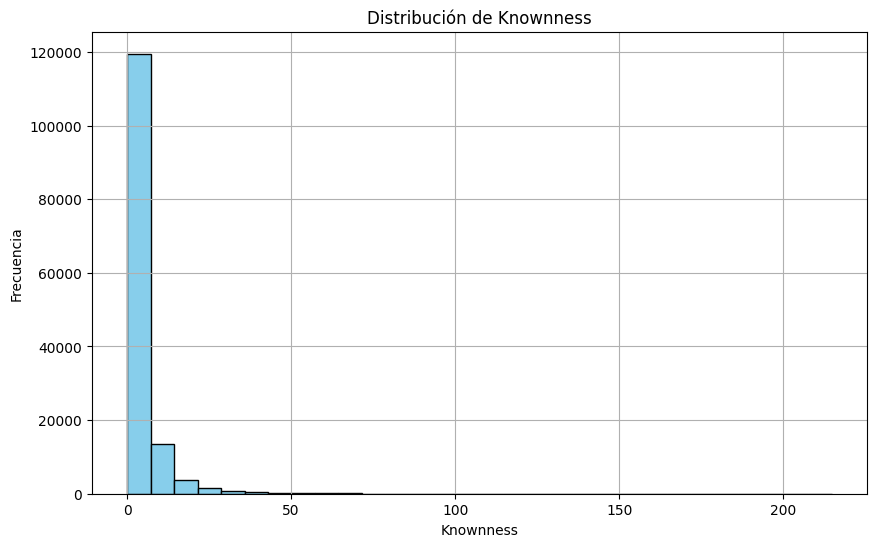

In [6]:
import matplotlib.pyplot as plt

# Configuración del gráfico
plt.figure(figsize=(10, 6))
plt.hist(df_pfam['knownness'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Knownness')
plt.xlabel('Knownness')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el histograma
plt.show()


In [7]:
# Dividir las cadenas de PFAM IDs en elementos individuales
pfam_ids_split = df_pfam['pfam_ids'].str.split(';')

# Crear una lista plana de todos los PFAM IDs
all_pfam_ids = [pfam_id for sublist in pfam_ids_split for pfam_id in sublist]

# Contar la frecuencia de cada PFAM ID único
pfam_id_counts = pd.Series(all_pfam_ids).value_counts()

# Mostrar los 10 PFAM IDs más comunes
print("Los 10 PFAM IDs más comunes:")
print(pfam_id_counts.head(10))

Los 10 PFAM IDs más comunes:
PF00069    3658
PF13853    3130
PF00096    2643
PF00001    1995
PF00076    1709
PF00046    1454
PF00400    1454
PF07714    1326
PF07686    1213
PF00071    1125
Name: count, dtype: int64


In [15]:
pfam_id_counts.info()

<class 'pandas.core.series.Series'>
Index: 8883 entries, PF00069 to PF04143
Series name: count
Non-Null Count  Dtype
--------------  -----
8883 non-null   int64
dtypes: int64(1)
memory usage: 396.8+ KB


In [20]:
archi_esc = open("pfam_id_aka2.csv", "w")
with open("pfam_id_aka.csv", "r") as archi:
    for linea in archi:
        primera_coma = linea.find(',')
        if primera_coma != -1:
            archi_esc.write(linea[:primera_coma] + "$" + linea[primera_coma+1:])
        else:
            archi_esc.write(linea)

archi_esc.close()

df_pfam_akas = pd.read_csv("pfam_id_aka2.csv", sep="$")
df_pfam_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8883 entries, 0 to 8882
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pfam_id   8883 non-null   object
 1   pfam_aka  8883 non-null   object
dtypes: object(2)
memory usage: 138.9+ KB


In [21]:
df_merged = pd.merge(pfam_id_counts, df_pfam_akas, left_index=True, right_on='pfam_id', how="left")
df_merged.set_index('pfam_id', inplace=True)
# Mostrar los 10 PFAM IDs más comunes
print("Los 10 PFAM IDs más comunes:")
print(df_merged.head(10))


Los 10 PFAM IDs más comunes:
         count                                      pfam_aka
pfam_id                                                     
PF00069   3658                         Protein kinase domain
PF13853   3130                            Olfactory receptor
PF00096   2643                        Zinc finger, C2H2 type
PF00001   1995   7 transmembrane receptor (rhodopsin family)
PF00076   1709                         RNA recognition motif
PF00046   1454                                   Homeodomain
PF00400   1454                      WD domain, G-beta repeat
PF07714   1326  Protein tyrosine and serine/threonine kinase
PF07686   1213                   Immunoglobulin V-set domain
PF00071   1125                                    Ras family


In [9]:
import requests

def get_pfam_aka(pfam_id):
    url = f"https://www.ebi.ac.uk/interpro/api/entry/pfam/{pfam_id}/"

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    json_data = response.json()
    if response.status_code == 200:
        if "metadata" in json_data:
            if "name" in json_data["metadata"]:
                if "name" in json_data["metadata"]["name"]:
                    return json_data["metadata"]["name"]["name"]
                
        return "NaN"
    return "404"

In [15]:
pfam_ids_unique = list(set(all_pfam_ids))

In [16]:
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, as_completed


# results = []
# archi = open("pfam_id_aka.csv", "w")

# def procesar_resultado(result):
#     pfam_id, nombre = result
#     if nombre:
#         archi.write(f"{pfam_id},{nombre}\n")

# with ThreadPoolExecutor(max_workers=11) as executor:
#     futures = {executor.submit(get_pfam_aka, pfam_id): pfam_id for pfam_id in pfam_ids_unique}
#     for future in tqdm(as_completed(futures), total=len(futures), desc="Retrieving PFAM name"):
#         pfam_id = futures[future]
#         try:
#             result = future.result()
#             results.append((pfam_id, result))
#         except Exception as e:
#             results.append((pfam_id, None))

# archi.write("pfam_id,pfam_aka")
# for result in results:
#     procesar_resultado(result)
# archi.close()

Retrieving PFAM name: 100%|██████████| 8883/8883 [20:14<00:00,  7.31it/s]
